<a href="https://colab.research.google.com/github/itsGab/mae_dinah/blob/main/nb_fcst/mae_dinah_em_acao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports & inicial data

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fbprophet import Prophet
import matplotlib as mpl
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_absolute_error

In [17]:
dados_curitiba = r'https://github.com/itsGab/mae_dinah/raw/main/dados/covid_curitiba.csv'
dados = pd.read_csv(dados_curitiba, index_col=0)
dados = pd.read_csv(dados_curitiba, index_col=0)
xdados = dados[['datahora', 'casos_novos', 'obitos_novos', 'casos_acumulados']]
xdados['datahora'] = pd.to_datetime(xdados['datahora'])
xdados.set_index('datahora', inplace=True)

In [18]:
# retirando outliers
xdados['casos_novos_t'] = xdados['casos_novos'].mask(xdados['casos_novos'] > 2500)
xdados['obitos_novos_t'] = xdados['obitos_novos'].mask(xdados['obitos_novos'] < 0, 0)

## Prophet (basic)

In [19]:
def xdados_cria_df(col_y: str):
    df = pd.DataFrame({'ds': pd.to_datetime(xdados.index), 'y': xdados[col_y]})
    return df

In [20]:
# criacao dos dataframe para o pfProphet
df_casos_novos = xdados_cria_df('casos_novos_t')
df_obitos_novos = xdados_cria_df('obitos_novos_t')

In [21]:
def basico_prophet(df_p, p=30, model=0):
    if model == 0:
        model = Prophet()
    model.fit(df_p)
    fut = model.make_future_dataframe(p)
    fcst = model.predict(fut)
    return model, fut, fcst

In [22]:
m, f, fc = basico_prophet(df_casos_novos)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


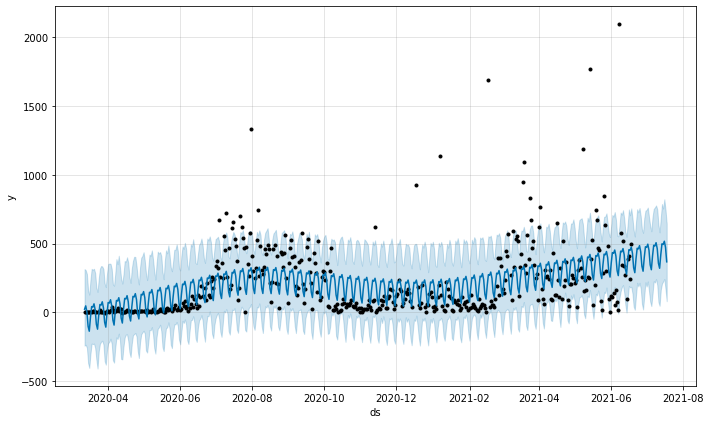

In [23]:
m.plot(fc);

In [24]:
# MAE
mae_basic = mean_absolute_error(df_casos_novos['y'].fillna(method='bfill'), fc['yhat'][:464])
mae_basic

147.01633725909716

## Prophet com sazonalidade de inverno

### Condition (winter)

Inverno: 21/06 a 22/09

In [25]:
def cond_inverno(ds):
    '''
    funcao para identificar os meses de inverno
    '''
    cond = False
    date = pd.to_datetime(ds)
    if date.month == 6 and date.day >= 21 or 6 < date.month < 9 or date.month == 9 and date.day <= 22:
        cond = True
    return cond

### Model

In [26]:
df_casos_novos['inverno'] = df_casos_novos['ds'].apply(cond_inverno)
model = Prophet()
model.add_country_holidays('BR')
model.add_seasonality(name='winter', period=365.5, fourier_order=3, condition_name='inverno')
model.fit(df_casos_novos[:400])
fut = model.make_future_dataframe(64)
fut['inverno'] = fut['ds'].apply(cond_inverno)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Plot (forecast)

[]

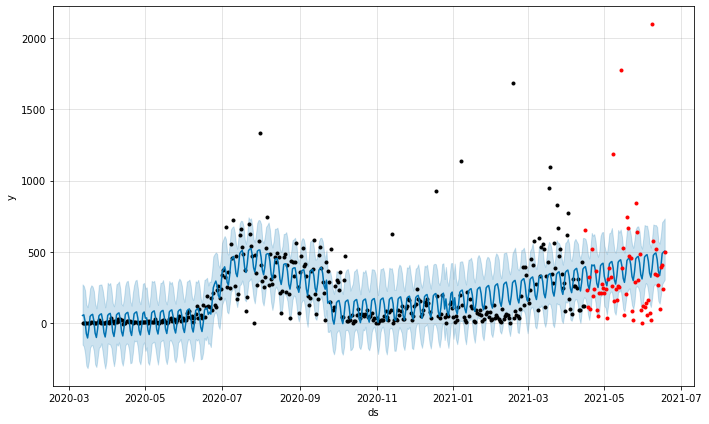

In [27]:
fcst = model.predict(fut)
model.plot(fcst);
plt.plot(df_casos_novos['ds'][400:], df_casos_novos['y'][400:], '.r')
plt.plot()

### Plot (components)

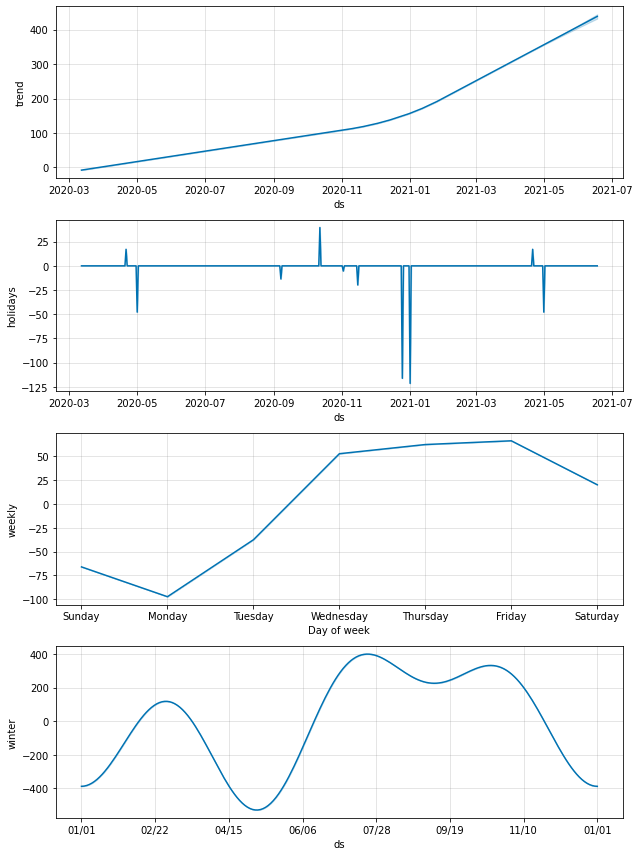

In [28]:
model.plot_components(fcst);

### Score

In [29]:
# MAE
mae_winter = mean_absolute_error(df_casos_novos['y'].fillna(method='bfill'), fcst['yhat'][:464])
mae_winter

127.87891256301496

## Comparison

Score do modelo do prophet basico, apenas sazonalidades automaticas do prophet

In [30]:
mae_basic

147.01633725909716

Score do modelo com inverno + feriados do Brasil

In [31]:
mae_winter

127.87891256301496